In [35]:
from tensorflow.keras.models import load_model
model = load_model('./my_model')
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import gym
import random
from collections import deque
import matplotlib.pyplot as plt

class DQNAgent:
    def __init__(self, state_size, action_size, model=None):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 0.01  # exploration rate, set low for evaluation
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = model if model is not None else self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = tf.keras.models.Sequential()
        model.add(layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(24, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))  # Updated line
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        loss = 0
        for state, action, reward, next_state, done in minibatch:
            target = reward if done else (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            history = self.model.fit(state, target_f, epochs=1, verbose=0)
            loss += history.history['loss'][0]
        return loss / len(minibatch)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

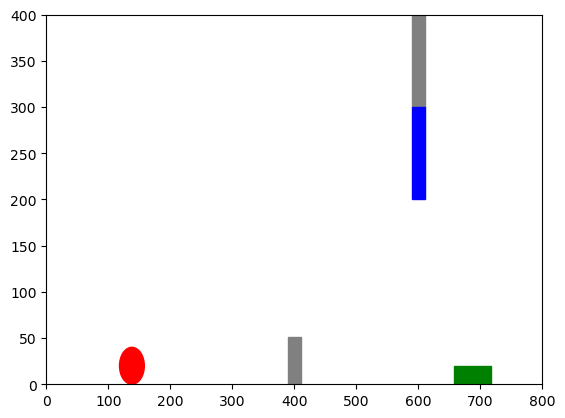

In [36]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Constants
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 400
BAR_WIDTH = 20
BAR_HEIGHT = 100
BALL_RADIUS = 20
BASKET_WIDTH = 60
BASKET_HEIGHT = 20
MOVEMENT_SPEED = 5
VELOCITY = 10

class BallSortCraneEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(BallSortCraneEnv, self).__init__()
        # Define action and observation space
        self.action_space = spaces.Discrete(5)
        self.observation_space = spaces.Box(low=0, high=max(SCREEN_WIDTH, SCREEN_HEIGHT), shape=(6,), dtype=np.float32)

        # Initialize game variables
        self.bar_x = SCREEN_WIDTH - (SCREEN_WIDTH // 4)
        self.bar_y = SCREEN_HEIGHT - (SCREEN_HEIGHT // 4)
        self.bar_height = BAR_HEIGHT
        self.extend_bar = False
        self.shrink_bar = False
        self.move_left = False
        self.move_right = False
        self.score = 0
        self.is_grabbing = False
        self.previous_distance_to_ball = float('inf')
        self.previous_distance_to_basket = float('inf')
        self.ball_x, self.ball_y, self.basket_x, self.basket_y, self.pillar_height = self.randomize_positions()
        self.figure, self.ax = plt.subplots()
        self.current_step = 0
        
    def randomize_positions(self):
        ball_x = random.randint(BALL_RADIUS, SCREEN_WIDTH // 2 - BALL_RADIUS)
        basket_x = random.randint(SCREEN_WIDTH // 2 + BASKET_WIDTH // 2, SCREEN_WIDTH - BASKET_WIDTH // 2)
        max_pillar_height = SCREEN_HEIGHT // 2
        pillar_height = random.randint(50, max_pillar_height)
        ball_y = BALL_RADIUS
        basket_y = BASKET_HEIGHT // 2
        return ball_x, ball_y, basket_x, basket_y, pillar_height

    def step(self, action):

        if action == 0:  # Move Left
            self.move_left = True
            self.move_right = False
        elif action == 1:  # Move Right
            self.move_left = False
            self.move_right = True
        elif action == 2:  # Extend Bar
            self.extend_bar = True
            self.shrink_bar = False
        elif action == 3:  # Shrink Bar
            self.extend_bar = False
            self.shrink_bar = True
        elif action == 4:  # Grab/Release
            self.is_grabbing = not self.is_grabbing
        self.current_step += 1
        self.update_game_state()

        reward = self.calculate_reward()
        done = self.is_game_done()
        obs = np.array([self.ball_x, self.ball_y, self.bar_x, self.bar_y, self.basket_x, self.basket_y], dtype=np.float32)

        return obs, reward, done, {}

    def reset(self):
        self.current_step = 0
        self.bar_x, self.bar_y, self.bar_height = SCREEN_WIDTH - (SCREEN_WIDTH // 4), SCREEN_HEIGHT - (SCREEN_HEIGHT // 4), BAR_HEIGHT
        self.extend_bar, self.shrink_bar, self.move_left, self.move_right, self.is_grabbing = False, False, False, False, False
        self.score = 0
        self.previous_distance_to_ball = float('inf')
        self.previous_distance_to_basket = float('inf')
        self.ball_x, self.ball_y, self.basket_x, self.basket_y, self.pillar_height = self.randomize_positions()
        return np.array([self.ball_x, self.ball_y, self.bar_x, self.bar_y, self.basket_x, self.basket_y], dtype=np.float32)

    def render(self, mode='human'):
        
        self.ax.clear()
        self.ax.set_xlim(0, SCREEN_WIDTH)
        self.ax.set_ylim(0, SCREEN_HEIGHT)

        # Draw the pillar in the middle of the screen
        pillar_x = SCREEN_WIDTH // 2
        pillar = patches.Rectangle((pillar_x - 10, 0), 20, self.pillar_height, color='gray')
        self.ax.add_patch(pillar)

        # Draw the crane's arm and bar
        crane_base_x = self.bar_x
        crane_base_y = SCREEN_HEIGHT
        crane_arm_length = SCREEN_HEIGHT - self.bar_y + self.bar_height
        crane_arm = patches.Rectangle((crane_base_x - BAR_WIDTH/2, self.bar_y), BAR_WIDTH, crane_arm_length, color='gray')
        self.ax.add_patch(crane_arm)
        bar = patches.Rectangle((self.bar_x - BAR_WIDTH/2, self.bar_y - self.bar_height), BAR_WIDTH, self.bar_height, color='blue')
        self.ax.add_patch(bar)

        # Draw the ball
        ball = patches.Circle((self.ball_x, self.ball_y), BALL_RADIUS, color='red')
        self.ax.add_patch(ball)

        # Draw the basket
        basket = patches.Rectangle((self.basket_x - BASKET_WIDTH/2, self.basket_y - BASKET_HEIGHT/2), BASKET_WIDTH, BASKET_HEIGHT, color='green')
        self.ax.add_patch(basket)
        
        if mode == 'rgb_array':
            # Convert the plot to an RGB array
            self.figure.canvas.draw()
            width, height = self.figure.get_size_inches() * self.figure.get_dpi()
            image = np.frombuffer(self.figure.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(int(height), int(width), 3)
            return image
        elif mode == 'human':
            # [Existing code for human rendering]
            plt.draw()
            plt.pause(0.01)

    def close(self):
        plt.close(self.figure)

    def update_game_state(self):
        # Update bar position
        if self.move_left:
            self.bar_x = max(self.bar_x - MOVEMENT_SPEED, BAR_WIDTH / 2)
        if self.move_right:
            self.bar_x = min(self.bar_x + MOVEMENT_SPEED, SCREEN_WIDTH - BAR_WIDTH / 2)

        # Update bar height
        if self.extend_bar and self.bar_height < SCREEN_HEIGHT - self.bar_y:
            self.bar_height += 10
        if self.shrink_bar and self.bar_height > 10:
            self.bar_height -= 10

        # Handle ball grabbing logic
        if self.is_grabbing:
            # Check if the bar is above the ball
            if self.bar_x - BAR_WIDTH / 2 < self.ball_x < self.bar_x + BAR_WIDTH / 2 and \
               self.ball_y < self.bar_y - self.bar_height + BALL_RADIUS:
                self.ball_x = self.bar_x
                self.ball_y = self.bar_y - self.bar_height + BALL_RADIUS
        else:
            # Ball falls due to gravity
            if self.ball_y > BALL_RADIUS:
                self.ball_y -= VELOCITY
            else:
                self.ball_y = BALL_RADIUS  # Ensure ball doesn't go below the ground


    def calculate_reward(self):
        reward = 0
        distance_to_ball = abs(self.ball_x - self.bar_x)
        distance_to_basket = abs(self.basket_x - self.bar_x)

        # Reward for grabbing the ball
        if self.is_grabbing and self.ball_y < self.bar_y - self.bar_height + BALL_RADIUS:
            reward += 1

        # Penalty for releasing the ball outside the basket
        if not self.is_grabbing and self.ball_y < BALL_RADIUS:
            if not (self.ball_x + BALL_RADIUS > self.basket_x - BASKET_WIDTH / 2 and 
                    self.ball_x - BALL_RADIUS < self.basket_x + BASKET_WIDTH / 2):
                reward -= 1

        # Reward for moving towards the ball when not holding it
        if not self.is_grabbing and self.previous_distance_to_ball > distance_to_ball:
            reward += 0.1

        # Reward for moving towards the basket when holding the ball
        if self.is_grabbing and self.previous_distance_to_basket > distance_to_basket:
            reward += 0.1

        # Update previous distances
        self.previous_distance_to_ball = distance_to_ball
        self.previous_distance_to_basket = distance_to_basket

        return reward

    def is_game_done(self):
        max_score = 10
        max_steps = 1000
        return self.score >= max_score or self.current_step >= max_steps


# Create and test your environment
env = BallSortCraneEnv()
env.reset()
env.render(mode='rgb_array')

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


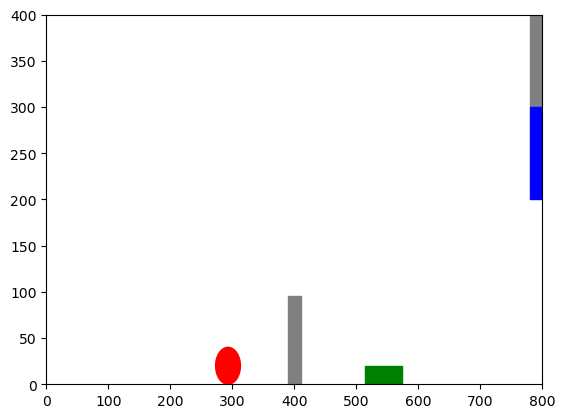

In [37]:
import imageio
import base64
import IPython

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

# Create the environment
env = BallSortCraneEnv()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Create the agent with the loaded model
agent = DQNAgent(state_size, action_size, model)
state_size = env.observation_space.shape[0]  # Define state_size here
# Create the agent with the loaded model
# Load the model
model = load_model('./my_model')
agent = DQNAgent(state_size, action_size, model)
num_episodes = 3
video_filename = 'ball_sort_crane_gameplay.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
    for _ in range(num_episodes):
        state = env.reset()
        video.append_data(env.render(mode='rgb_array'))
        done = False
        while not done:
            state = np.reshape(state, [1, state_size])
            action = agent.act(state)  # Ensure your agent is already defined
            next_state, reward, done, _ = env.step(action)
            state = next_state
            video.append_data(env.render(mode='rgb_array'))

embed_mp4(video_filename)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]